In [245]:
import ccxt
import talib
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from os import getenv
from dotenv import load_dotenv

load_dotenv()


True

In [124]:
exchange_id = 'binance'
exchange_class = getattr(ccxt, exchange_id)
exchange = ccxt.binance()
exchange = exchange_class({'apiKey': getenv('BINANCE_API '), 'secret': getenv('BINANCE_SECRET')})

In [246]:
data = pd.read_parquet('data/eth_data.parquet')

last_date = int(round(data['date'].iloc[-1].timestamp() * 1000)) + 1

new_data_query = exchange.fetch_ohlcv('ETH/USDT', '5m', limit=250, since=last_date)

new_data = pd.DataFrame(new_data_query[:-1], columns=['at', 'open', 'high', 'low', 'close', 'vol'])
new_data['date'] = pd.to_datetime(new_data['at'], unit='ms')
new_data.drop('at', axis=1, inplace=True)

if len(new_data) > 0:
    data = pd.concat([data, new_data])
    data.reset_index()
    data.to_parquet('data/eth_data.parquet')

data = pd.read_parquet('data/eth_data.parquet')

In [247]:
df = data.copy()
df.set_index('date', inplace=True)
close = df['close'].values
df['rsi'] = talib.RSI(close, timeperiod=14)
df['BB_up'], df['BB_mid'], df['BB_low'] = talib.BBANDS(close, timeperiod=20, nbdevup=2.3, nbdevdn=2.3, matype=0)
df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
df['atr'] = talib.ATR(df['high'].values, df['low'].values, close, timeperiod=14)
df['obv'] = talib.OBV(close, df['vol'].values)
df['EMA20'] = talib.EMA(df.close, 20)
df['EMA50'] = talib.EMA(df.close, 50)
df['EMA200'] = talib.EMA(df.close, 200)


df['percent_change'] = df['close'].pct_change() * 100
df['percent_change'].fillna(0, inplace=True)
df['move'] = df['percent_change'].apply(lambda x: 0 if x <= 0 else 1)

training_set = df.resample('30min', label='right').agg({'close': 'last', 'open' : 'first', 'rsi': 'last', 'BB_up': 'last', 'BB_mid': 'last', 'BB_low': 'last', 'macd': 'last', 'macdsignal': 'last', 'macdhist': 'last', 'EMA20': 'last', 'EMA50': 'last', 'EMA200': 'last', 'atr': 'last', 'obv': 'last', 'vol': 'sum'})
training_set['date'] = training_set.index
training_set.reset_index(drop=True, inplace=True)
training_set.fillna(method='ffill', inplace=True)

<AxesSubplot:xlabel='date'>

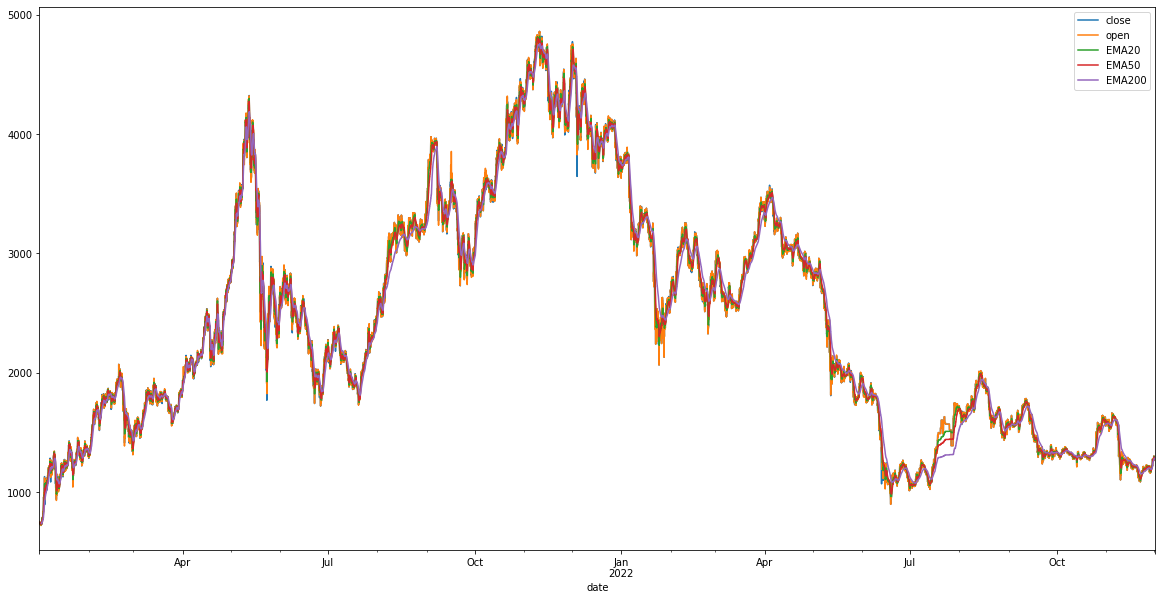

In [248]:
training_set.plot(y=['close', 'open', 'EMA20', 'EMA50', 'EMA200'], x='date', figsize=(20, 10))

In [249]:
training_set['close'] = training_set['close'].shift(-1)
training_set = training_set.iloc[200:] # Because of moving averages and MACD line
training_set = training_set[:-1]      # Because of shifting close price

In [250]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(training_set.shape[0] * (1-test_size))
valid_split_idx = int(training_set.shape[0] * (1-(valid_size+test_size)))

train_df  = training_set.loc[:valid_split_idx].copy()
valid_df  = training_set.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = training_set.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.date, y=train_df.close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.date, y=valid_df.close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.date,  y=test_df.close,  name='Test'))
fig.show()

In [251]:
drop_cols = ['date', 'vol', 'open']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

C:\Users\PC\AppData\Local\Temp\ipykernel_10076\2249414496.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\PC\AppData\Local\Temp\ipykernel_10076\2249414496.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\PC\AppData\Local\Temp\ipykernel_10076\2249414496.py:5: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [252]:
target = 'close'

y_train = train_df[target].copy()
X_train = train_df.drop([target], 1)

y_valid = valid_df[target].copy()
X_valid = valid_df.drop([target], 1)

y_test  = test_df[target].copy()
X_test  = test_df.drop([target], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23175 entries, 200 to 23374
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rsi         23175 non-null  float64
 1   BB_up       23175 non-null  float64
 2   BB_mid      23175 non-null  float64
 3   BB_low      23175 non-null  float64
 4   macd        23175 non-null  float64
 5   macdsignal  23175 non-null  float64
 6   macdhist    23175 non-null  float64
 7   EMA20       23175 non-null  float64
 8   EMA50       23175 non-null  float64
 9   EMA200      23175 non-null  float64
 10  atr         23175 non-null  float64
 11  obv         23175 non-null  float64
dtypes: float64(12)
memory usage: 2.1 MB


C:\Users\PC\AppData\Local\Temp\ipykernel_10076\2815950479.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\PC\AppData\Local\Temp\ipykernel_10076\2815950479.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\PC\AppData\Local\Temp\ipykernel_10076\2815950479.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [ ]:
def objective(trial):
    
    param = {
            'tree_method':'hist',  #this parameter means using the GPU when training our model to speedup the training process
            'n_estimators': trial.suggest_categorical('n_estimators', [300, 700, 1500]),
            'objective': trial.suggest_categorical('objective', ['reg:squarederror']),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.0, 1.0),
            'subsample': trial.suggest_float('subsample', 0.0, 1.0),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1),
            'max_depth': trial.suggest_int('max_depth', 3, 5),
            'random_state': trial.suggest_categorical('random_state', [2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 10, 300),
            'eval_metric': trial.suggest_categorical('eval_metric', ['mae'])
        }
    
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, 'validation_0-mae')
    model = xgb.XGBRegressor(**param)  
    
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=20, callbacks=[pruning_callback])
    
    preds = model.predict(X_test)
    
    mae = mean_squared_error(y_test, preds)
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, show_progress_bar=True)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [238]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[14:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "eval_set", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:14:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "eval_set", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:14:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "eval_set", "verbose" } migh

In [253]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.02, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

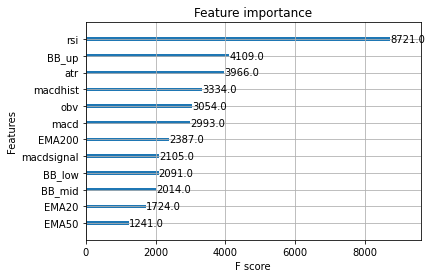

In [254]:
plot_importance(model);

In [255]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [1900.98391795 1906.50746868 1906.50746868 1904.30567467 1904.30567467]
y_pred = [1886.7616 1886.7616 1890.2096 1890.2096 1890.6543]


In [256]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 258.7119816022293


In [257]:
predicted_prices = training_set.loc[test_split_idx+1:].copy()
predicted_prices['close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=training_set.date, y=training_set.close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=predicted_prices.close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()